# Algorithm Performance Assessment

The following performance assessment of the CIMR L2 TSA algorithm focuses predominantly on the radiometric scene of the Demonstration Reference Scenario.

```{seealso}
Refer to the {ref}`content:annex` for a demonstration of the TSA algorithm for the SCEPS Polar Scene (see [Jupyter Notebook](../algorithm/CIMR_L2_TSA_SCEPS.ipynb)).
```

## L1 E2ES Demonstration Reference Scenario (Picasso) scene definition

The Demonstration Reference Scenario consists of two scenes, highlighting radiometric and geometric properties, respectively.
Each scene encorporates up to 8 different surface types, including sea ice (first and multi-year ice), land (snow-free and snow-covered), and open ocean (four states of varying sea surface temperature and salinity).
Each surface condition has allocated a representative {term}`TB` for each {term}`CIMR` channel and polarisation, with the land TBs being provided in {numref}`picasso_tb`.

```{table} Brightness temperatures of horizontal and vertical polarization for snow-free and snow-covered land.
:name: picasso_tb


| &nbsp; | Snow-covered | TB h-pol (K) | TB v-pol (K) | Snow-free | TB h-pol (K) | TB v-pol (K) |
| :-- | -------------- | ------------ | ------------ | :---------------- | ------------ | ------------ |
| L  (1.4GHz)    |  &nbsp; | 229          |  247         |    |  240         |  262         |
| C  (6.9GHz)    | &nbsp;  | 239          |  257         |    |  248         |  252         |
| X  (10.9GHz)   | &nbsp;  | 248          |  261         |    |  247         |  251         |
| Ku (18.7GHz)   | &nbsp;  | 261          |  266         |    |  248         |  260         |
| Ka (36.5GHz)   | &nbsp;  | 259          |  262         |    |  245         |  240         |
```

In the radiometric scene, all surface types are placed adjacent to each other to artificially construct all possible boundary transitions, whilst also providing sea ice concentration sub-resolution gradients (see {numref}`picasso-scene`, left).
The geometric scene, on the other hand, features high-contrast brightness temperature patterns for ocean parameters (see {numref}`picasso-scene`, right).

```{figure} ./figures/picasso-scene.png
--- 
name: picasso-scene
width: 500px
---
Demonstration Reference Scenario (Picasso) including a radiometric scene (left) and a geometric scene (right).
```

## Algorithm Performance Metrics (MPEF)

The performance of the binary TSA algorithm is evaluated by means of a confusion matrix set-up.
For this, TSA estimates are divided into true positive ({term}`TP`), false positive ({term}`FP`), true negative ({term}`TN`) and false negative ({term}`FN`) observations.
Those observation classes are used to calculate the classification accuracy per scene:

```{math}
:label: accuracy
\text{accuracy} = \frac{\text{TP}+\text{TN}}{\text{TP}+\text{FP}+\text{TN}+\text{FN}}.
```

The evaluation addresses the main TSA product incorporating TB data from forward and backward scans.
Metrics are further computed separately for the forward and the backward scan to demonstrate the concept's suitability.

## Algorithm Calibration Data Set (ACDAT)

N/a

## Algorithm Validation Data Set (AVDAT)

N/a

## Test Results using Demonstration Reference Scenario

The algorithm performance assessment for the radiometric scene as well as the algorithm demonstration for the geometric scene follow the overall procedure:

- Definition of the Coordinate Reference System ({term}`CRS`)
- Loading and visualisation of the scene's ground truth
- Read in TB data collocated to the Ka-band channel
- Run the TSA algorithm incl. reprojection to the CRS

In [1]:
import os 
import sys
import numpy as np
import xarray as xr
import pyresample as pr
import importlib
from matplotlib import pyplot as plt
from matplotlib import colors
from cartopy import crs as ccrs

# local imports
if '/algorithm/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/')
if '/tools/' not in sys.path:
    sys.path.insert(0, os.path.abspath('../.../') + 'algorithm/tools/')
import l2_format as l2
import TSA_algorithm as algorithm
import l2_tools as tools

In [2]:
# reload local imports
importlib.reload(l2)
importlib.reload(algorithm)
importlib.reload(tools)

<module 'l2_tools' from 'c:\\Users\\zschende\\OneDrive - Ilmatieteen laitos\\Files\\Projects\\CIMR Devalgo\\ATBD\\TerrestrialSnowArea_ATBD_v2\\algorithm/tools\\l2_tools.py'>

For the performance assessment, the {term}`CRS` corresponds to the native grid of the Demonstration Reference Scenario, namely EASE-Grid 2.0 polar projection of the Northern Hemisphere with a spatial resolution of 1km.
Outputs of the TSA algorithm are reprojected to this grid for a comparison with the test card ground truth.

In [3]:
l2_grid = 'ease2-1.0km-testcard'
area_def = pr.load_area('../algorithm/ease2_adef.yaml',l2_grid)

cart_crs = area_def.to_cartopy_crs()
trg_lon, trg_lat = area_def.get_lonlats()

### Radiometric Demonstration Reference Scenario

The snow cover conditions in the radiometric scene simulate an established snowpack of sufficient snow depth and snow density to cause noticeable volume scattering effects for Ka-band brightness temperatures.
Challenging conditions such as shallow or wet snow are not represented, nor are complex terrain or lake ice.
Therefore, the results should be interpreted as optimistic. 

In [4]:
# load ground truth of test card
test_card_name = 'devalgo_radiometric'

dem_ref_scene = os.path.abspath('../../../..../') + 'Data/Test_scenes_downscaled_projected/test_scene_1_compressed_lowres.nc'
data_rad = xr.open_dataset(dem_ref_scene)

# mirror ground truth on x-axis
landmask_rad = np.flip(data_rad['landflag'].values,0)
surfaces_rad = np.flip(data_rad['surfaces'].values,0)
lon_rad = np.flip(data_rad['Longitude'].values,0)
lat_rad = np.flip(data_rad['Latitude'].values,0)

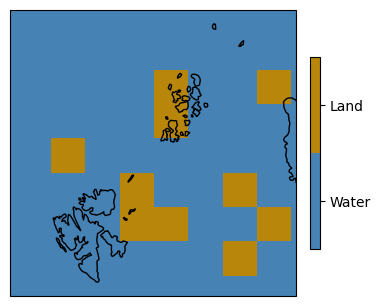

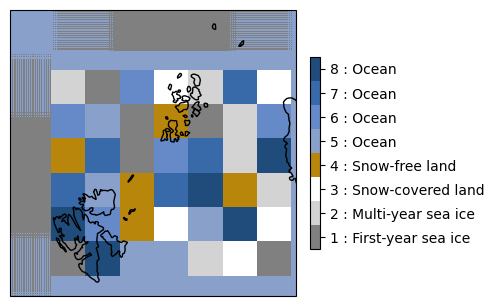

In [5]:
cmap = colors.ListedColormap(['steelblue', 'darkgoldenrod'])
vrange=[-0.5,0.5,1.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(lon_rad, lat_rad, landmask_rad, transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Water', 'Land'])
ax.coastlines()
plt.gcf().set_size_inches((4,4))
plt.show()

cmap = colors.ListedColormap(['grey', 'lightgrey', 'white', 'darkgoldenrod', '#89A0CA', '#658AC7', '#3869A8', '#1F4C7B'])
vrange=[0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(lon_rad, lat_rad, surfaces_rad, transform=ccrs.PlateCarree(), cmap=cmap)
# ax.set_title('Test Card Surfaces')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[1,2,3,4,5,6,7,8], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['1 : First-year sea ice', '2 : Multi-year sea ice', '3 : Snow-covered land', '4 : Snow-free land', '5 : Ocean', '6 : Ocean', '7 : Ocean', '8 : Ocean'])
ax.coastlines()
plt.gcf().set_size_inches((4,4))
plt.show()

Testing:

In [6]:
if test_card_name == 'devalgo_radiometric':
    l1x = os.path.abspath('../../../..../') + 'Data/L1C Files/Radiometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card_name == 'devalgo_geometric':
    l1x = os.path.abspath('../../../..../') + 'Data/L1C Files/Geometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'

data_fwd,geoloc_fwd,data_bck,geoloc_bck = tools.read_l1x(l1x)

In [7]:
# TSA algorithm
algo = 'Pulliainen2010'

TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

TSA_fwd_rad = tools.reproject_to_grid(TSA_fwd,geoloc_fwd,area_def=area_def,radius_of_influence=5000)
TSA_bck_rad = tools.reproject_to_grid(TSA_bck,geoloc_bck,area_def=area_def,radius_of_influence=5000)

TSA_rad, TSA_uncert_rad = tools.combine_proj(TSA_fwd_rad,TSA_bck_rad)

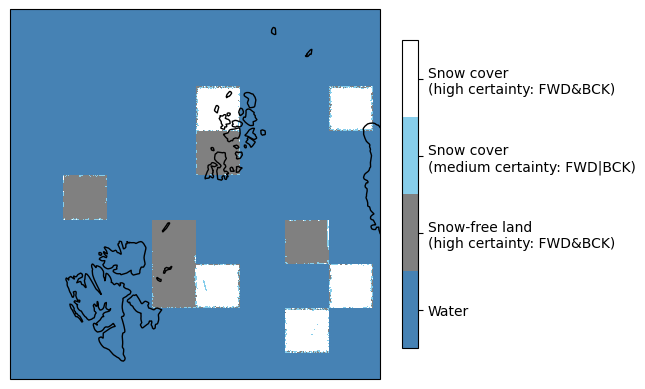

In [8]:
TSA_plot_rad = TSA_uncert_rad + 1
TSA_plot_rad[landmask_rad == 0] = 0                              # water
TSA_plot_rad[TSA_plot_rad == 2] = 3 
TSA_plot_rad[TSA_plot_rad == 1.5] = 2

cmap = colors.ListedColormap(['steelblue', 'grey', 'skyblue', 'white'])
vrange=[-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_plot_rad, transform=ccrs.PlateCarree(), cmap=cmap)
# ax.set_title('Radiometric Test Card Evaluation')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,1,2,3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Water', 'Snow-free land\n(high certainty: FWD&BCK)', 'Snow cover\n(medium certainty: FWD|BCK)', 'Snow cover\n(high certainty: FWD&BCK)'])
ax.coastlines()
# plt.gcf().set_size_inches((20,20))

# plt.savefig('tsa_uncert.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

### Geometric Demonstration Reference Scenario

In [9]:
# load ground truth of test card
test_card_name = 'devalgo_geometric'

dem_ref_scene = os.path.abspath('../../../..../') + 'Data/Test_scenes_downscaled_projected/test_scene_2_compressed_lowres.nc'
data_geo = xr.open_dataset(dem_ref_scene)

# mirror ground truth on x-axis
# landmask_geo = np.flip(data_ref['landflag'].values,0)
surfaces_geo = np.flip(data_geo['surfaces'].values,0)
lon_geo = np.flip(data_geo['Longitude'].values,0)
lat_geo = np.flip(data_geo['Latitude'].values,0)

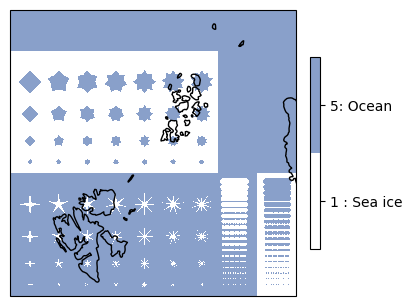

In [10]:
cmap = colors.ListedColormap(['white', '#89A0CA'])
vrange=[-0.5,0.5,5.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(lon_geo, lat_geo, surfaces_geo, transform=ccrs.PlateCarree(), cmap=cmap)
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[0,3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['1 : Sea ice', '5: Ocean'])
ax.coastlines()
plt.gcf().set_size_inches((4,4))

plt.show()

Testing:

In [11]:
if test_card_name == 'devalgo_radiometric':
    l1x = os.path.abspath('../../../..../') + 'Data/L1C Files/Radiometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230420T103323_LD_20280110T114800_20280110T115700_TN.nc'
elif test_card_name == 'devalgo_geometric':
    l1x = os.path.abspath('../../../..../') + 'Data/L1C Files/Geometric/W_PT-DME-Lisbon-SAT-CIMR-1X@KA_C_DME_20230417T105425_LD_20280110T114800_20280110T115700_TN.nc'

data_fwd,geoloc_fwd,data_bck,geoloc_bck = tools.read_l1x(l1x)

In [12]:
# TSA algorithm
algo = 'Pulliainen2010'

TSA_fwd = algorithm.dry_snow_detection(data_fwd,tsa_algorithm=algo)
TSA_bck = algorithm.dry_snow_detection(data_bck,tsa_algorithm=algo)

TSA_fwd_geo = tools.reproject_to_grid(TSA_fwd,geoloc_fwd,area_def=area_def,radius_of_influence=5000)
TSA_bck_geo = tools.reproject_to_grid(TSA_bck,geoloc_bck,area_def=area_def,radius_of_influence=5000)

TSA_geo, TSA_uncert_geo = tools.combine_proj(TSA_fwd_geo,TSA_bck_geo)

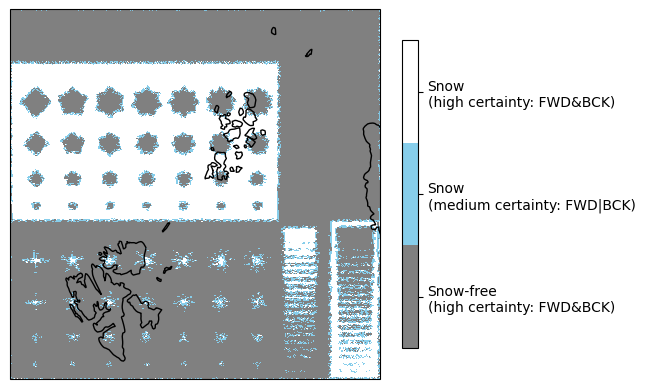

In [13]:
TSA_plot_geo = TSA_uncert_geo + 1
# TSA_plot_geo[landmask_geo == 0] = 0                              # no water mask for geometric scene
TSA_plot_geo[TSA_plot_geo == 2] = 3 
TSA_plot_geo[TSA_plot_geo == 1.5] = 2

cmap = colors.ListedColormap(['grey', 'skyblue', 'white'])
vrange=[0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_plot_geo, transform=ccrs.PlateCarree(), cmap=cmap)
# ax.set_title('Geometric Test Card Evaluation')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[1,2,3], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Snow-free\n(high certainty: FWD&BCK)', 'Snow\n(medium certainty: FWD|BCK)', 'Snow\n(high certainty: FWD&BCK)'])
ax.coastlines()
# plt.gcf().set_size_inches((20,20))

# plt.savefig('tsa_uncert2.png', format='png', dpi=1200, bbox_inches='tight')
plt.show()

## Algorithm Performance Assessment using Demonstration Reference Scenario

The core of the performance assessment is conducted using the radiometric test card, as it covers snow-free as well as snow-covered land surfaces.
The performance metrics are computed for the standard TSA algorithm combining forward and backward scan data, as well as for individual scans.
Note that the choice of reprojection parameters introduces an uncertainty in the evaluation metrics of about $\pm$3%.

Forward and backward scan:

In [14]:
TSA_rad_diff = np.zeros(TSA_rad.shape)
TSA_rad_diff[TSA_rad_diff == 0] = np.nan

TSA_rad_diff[(surfaces_rad == 3) & (TSA_rad == 0)] = -1  # FN
TSA_rad_diff[(surfaces_rad == 3) & (TSA_rad == 1)] = 0   # TP
TSA_rad_diff[(surfaces_rad == 4) & (TSA_rad == 0)] = 1   # TN
TSA_rad_diff[(surfaces_rad == 4) & (TSA_rad == 1)] = 2   # FP
TSA_rad_diff[landmask_rad == 0] = -2                               # water
TSA_rad_diff[(surfaces_rad == 1) | (surfaces_rad == 2)] = -3       # sea ice

In [15]:
# count evaluated pixels
unique, counts = np.unique(TSA_rad_diff, return_counts=True)
# print(dict(zip(unique,counts)))
fn = counts[2]              # -1: FN
tp = counts[3]              #  0: TP
tn = counts[4]              #  1: TN
fp = counts[5]              #  2: FP
total = np.sum(counts[2:])  # ignore water and sea ice for total count

acc = np.sum(tp+tn)/total
print('Accuracy:', "%.5f" % acc)
tpr = tp/(np.sum(tp+fn))
print('TP rate: ', "%.5f" % tpr)
tnr = tn/(np.sum(tn+fp))
print('TN rate: ', "%.5f" % tnr)

Accuracy: 0.95989
TP rate:  0.95590
TN rate:  0.96387


In [16]:
print('Confusion Matrix')
print('TP = ', tp, ' | ', 'FP = ', fp)
print('FN = ', fn, '   | ', 'TN = ', tn)

Confusion Matrix
TP =  134897  |  FP =  5099
FN =  6223    |  TN =  136021


The tendency to underestimate snow presence is reflected by the true negative rate which is higher than the true positive rate.
For the given test card grid, the TSA algorithm detects a snow cover extent of 134,897km{sup}`2` out of the ground truth of 141,120km{sup}`2`.

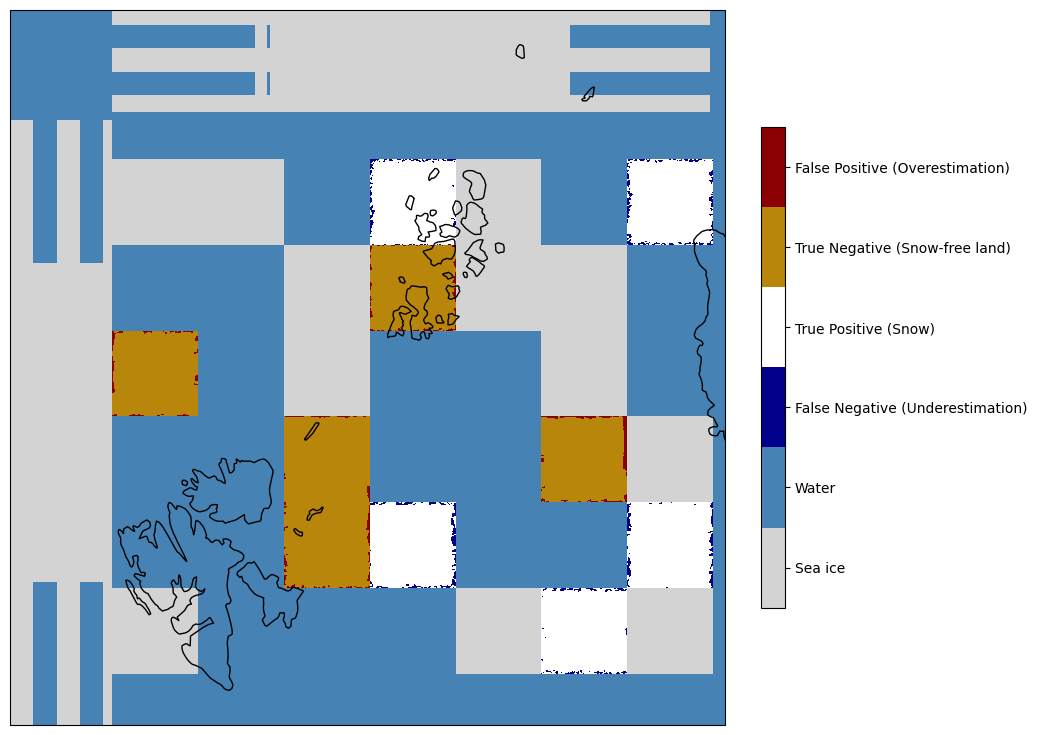

In [17]:
cmap = colors.ListedColormap(['lightgrey','steelblue','darkblue', 'white', 'darkgoldenrod', 'darkred'])
vrange=[-3.5,-2.5,-1.5,-0.5,0.5,1.5,2.5]
norm = colors.BoundaryNorm(vrange, cmap.N)

ax = plt.axes(projection=ccrs.LambertAzimuthalEqualArea(central_latitude=+90.0))
img = ax.pcolormesh(trg_lon, trg_lat, TSA_rad_diff, transform=ccrs.PlateCarree(), cmap=cmap)
# ax.set_title('Test Card Evaluation')
cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=vrange, ticks=[-3, -2,-1,0,1,2], fraction=0.031, pad=0.046)
cbar.ax.set_yticklabels(['Sea ice', 'Water', 'False Negative (Underestimation)', 'True Positive (Snow)', 'True Negative (Snow-free land)', 'False Positive (Overestimation)'])
ax.coastlines()
plt.gcf().set_size_inches((10,10))

plt.show()

For the forward scan, the following metrics are obtained:

In [18]:
TSA_fwd_rad_diff = np.zeros(TSA_fwd_rad.shape)
TSA_fwd_rad_diff[TSA_fwd_rad_diff == 0] = np.nan

TSA_fwd_rad_diff[(surfaces_rad == 3) & (TSA_fwd_rad == 0)] = -1  # FN
TSA_fwd_rad_diff[(surfaces_rad == 3) & (TSA_fwd_rad == 1)] = 0   # TP
TSA_fwd_rad_diff[(surfaces_rad == 4) & (TSA_fwd_rad == 0)] = 1   # TN
TSA_fwd_rad_diff[(surfaces_rad == 4) & (TSA_fwd_rad == 1)] = 2   # FP
TSA_fwd_rad_diff[landmask_rad == 0] = -2                               # water
TSA_fwd_rad_diff[(surfaces_rad == 1) | (surfaces_rad == 2)] = -3       # sea ice

In [19]:
# count evaluated pixels
unique, counts = np.unique(TSA_fwd_rad_diff, return_counts=True)
# print(dict(zip(unique,counts)))
fn = counts[2]              # -1: FN
tp = counts[3]              #  0: TP
tn = counts[4]              #  1: TN
fp = counts[5]              #  2: FP
total = np.sum(counts[2:])  # ignore water and sea ice for total count

acc = np.sum(tp+tn)/total
print('Accuracy:', "%.5f" % acc)
tpr = tp/(np.sum(tp+fn))
print('TP rate: ', "%.5f" % tpr)
tnr = tn/(np.sum(tn+fp))
print('TN rate: ', "%.5f" % tnr)

Accuracy: 0.95212
TP rate:  0.92301
TN rate:  0.98124


For the backward scan, the following metrics are obtained:

In [20]:
TSA_bck_rad_diff = np.zeros(TSA_bck_rad.shape)
TSA_bck_rad_diff[TSA_bck_rad_diff == 0] = np.nan

TSA_bck_rad_diff[(surfaces_rad == 3) & (TSA_bck_rad == 0)] = -1  # FN
TSA_bck_rad_diff[(surfaces_rad == 3) & (TSA_bck_rad == 1)] = 0   # TP
TSA_bck_rad_diff[(surfaces_rad == 4) & (TSA_bck_rad == 0)] = 1   # TN
TSA_bck_rad_diff[(surfaces_rad == 4) & (TSA_bck_rad == 1)] = 2   # FP
TSA_bck_rad_diff[landmask_rad == 0] = -2                               # water
TSA_bck_rad_diff[(surfaces_rad == 1) | (surfaces_rad == 2)] = -3       # sea ice

In [21]:
# count evaluated pixels
unique, counts = np.unique(TSA_bck_rad_diff, return_counts=True)
# print(dict(zip(unique,counts)))
fn = counts[2]              # -1: FN
tp = counts[3]              #  0: TP
tn = counts[4]              #  1: TN
fp = counts[5]              #  2: FP
total = np.sum(counts[2:])  # ignore water and sea ice for total count

acc = np.sum(tp+tn)/total
print('Accuracy:', "%.5f" % acc)
tpr = tp/(np.sum(tp+fn))
print('TP rate: ', "%.5f" % tpr)
tnr = tn/(np.sum(tn+fp))
print('TN rate: ', "%.5f" % tnr)

Accuracy: 0.94831
TP rate:  0.91927
TN rate:  0.97735


Both the accuracy and the TP rate are higher for the TSA product when using combined rather than individual scans.
Passive microwave snow detection approaches commonly underestimate snow cover area, which can be counteracted when incorporating both scan directions.

## Summary

An initial performance assessment of the CIMR L2 TSA algorithm is conducted using primarily the radiometric scene of the Demonstration Reference Scenario (Picasso).
The radiometric scene contains two land surface types: snow-free and snow-covered ground.
Note that distinct bare ground as well as established snowpacks are represented, while more challenging conditions such as shallow or wet snow, complex terrain, dense vegetation, and lake ice are not considered.
Due to this idealistic nature of the artificial scene, high algorithm performance is to be expected.
Indeed, the TSA algorithm achieves an accuracy of 95.99% together with a true positive rate of 95.59% and a true negative rate of 96.39%.

Although the performance is very high, the metrics still reflect the common tendency of passive microwave snow detection methodologies to underestimate snow cover area, as the true negative rate is larger than the true positive rate.
False negative pixels, i.e. pixels affected by underestimation are predominantly found in proximity to land-water boundaries.
Although more dependent on different sea and sea ice conditions, false positive pixels representing overestimation similarly form elongated clusters along 'coastlines'. 
Even this simple test scene therefore emphasises the need for water spill-over corrections.

Despite their simplicity, both scenes of the Demonstration Reference Scenario provide insights into the utility of CIMR's scanning geometry.
In case of the radiometric scene, combining snow area estimates from both forward and backward-looking brightness temperatures proves beneficial.
The overall algorithm performance is better when compared to snow area estimates from only one look direction.
This supports the current approach of combining snow area estimates after separate processing of forward and backward scans.
In case of the geometric scene, land surface types are not included.
Nevertheless, the high-contrast brightness temperature patterns happen to provide a visualisation of the implemented TSA uncertainty flag, highlighting its behaviour and utility along sharp borders and gradient transitions.
Both aspects encourage the partition of CIMR brightness temperatures depending on look direction.

In contrast to the Demonstration Reference Scenario, more realistic conditions are found in the SCEPS Polar Scene.
Yet when applying the TSA algorithm to said polar scene, barely any snow cover is detected over land.
The primary condition for snow cover to be detected relies on a depression in Ka-band brightness temperature of horizontal polarisation, due to volume scattering effects of snowpacks.
This is simply not met for the vast majority of the land area.
It is understood that sample emissivities might have been used for the simulation of land parts contained within the scene.
Those emissivities likely reflect glacial conditions, which would not result in volume scattering effects due to the continuous transition between snow, firn, and glacial ice.
Similarly, Ku-band brightness temperatures serve as scatter-free reference which relies on a clear interface between the snowpack and the subnivean substrate.
Terrestrial snow detection approaches are hence not applicable over glaciers and ice caps.

Overall, the performance of the TSA algorithm is successfully demonstrated for the different test scenarios.
Even though synthetic data naturally cannot fully replace real data, the assessment provides a first proof of concept for the algorithm's handling of forward and backward brightness temperatures in order to estimate snow area and its qualitative uncertainty.